# Tweet Sentiment and Stock Market Change Analysis for Donald Trump
### Dependencies
##### Un-comment to run as-needed

In [1]:
#somewhat uncommon libs used in this notebook:
#!pip install text
#!pip install yfinance
#!pip install vaderSentiment
#!pip install GetOldTweets3
#!pip install textblob
#!pip install unicodedata
#!pip install -U spacy
#!python -m spacy download en_core_web_sm

### Imports

In [2]:
#imports and workbook config
import GetOldTweets3 as got
from textblob import TextBlob
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import time
import warnings
import matplotlib
import matplotlib.pyplot as plt
import unicodedata
import spacy
from spacy.matcher import PhraseMatcher
import nltk
import re as re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import en_core_web_sm

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

plt.style.use('fivethirtyeight')
matplotlib.rcParams['figure.figsize'] = (20,10) #(12, 6)
matplotlib.rcParams['font.size'] = 10

#establish criteria for extracting tweets using GetOldTweets3 library
nTweets = 14000

today = datetime.datetime.today().strftime('%Y-%m-%d')
tweetCriteria = got.manager.TweetCriteria().setUsername("realDonaldTrump")\
                                           .setSince("2017-01-20")\
                                           .setUntil(today)                         

### Tweet Extraction Using Getoldtweets3
##### Note: this is time-consuming and a previous extraction can be imported below from csv

In [3]:
#fetch tweets according to the criteria above
tweet = got.manager.TweetManager.getTweets(tweetCriteria)
print(len(tweet))


11788


In [4]:
#Perform sample textblob sentiment analysis on latest 10 tweets
#something of a basic functional check
for i in range(0, 10): 
    print(tweet[i].text)
    print('-----------------------')
    print(TextBlob(tweet[i].text).sentiment)
    print('-----------------------')


LAW & ORDER!
-----------------------
Sentiment(polarity=0.0, subjectivity=0.0)
-----------------------
Our National Guard stopped them cold last night. Should have been called up sooner!
-----------------------
Sentiment(polarity=-0.3, subjectivity=0.5333333333333333)
-----------------------
Get tough Democrat Mayors and Governors. These people are ANARCHISTS. Call in our National Guard NOW. The World is watching and laughing at you and Sleepy Joe. Is this what America wants? NO!!!
-----------------------
Sentiment(polarity=0.0008680555555555525, subjectivity=0.4666666666666667)
-----------------------
Law & Order in Philadelphia, NOW! They are looting stores. Call in our great National Guard like they FINALLY did (thank you President Trump) last night in Minneapolis. Is this what voters want with Sleepy Joe? All Dems!
-----------------------
Sentiment(polarity=0.26666666666666666, subjectivity=0.6055555555555555)
-----------------------
The Lamestream Media is doing everything within 

In [5]:
#extract content from tweets, append to lists
ids = []
permalinks = []
usernames = []
whoto = []
tweettext = []
tweetdate = []
Retweets = []
Favorites = []
Mentions = []
Hashtags = []
Geo = []

#loop through tweets, extract data item from each tweet and put in list
for i in range(0,len(tweet)):
    ids.append(tweet[i].id)
    permalinks.append(tweet[i].permalink)
    usernames.append(tweet[i].username)
    whoto.append(tweet[i].to)
    tweettext.append(tweet[i].text)
    tweetdate.append(tweet[i].date)
    Retweets.append(tweet[i].retweets)
    Favorites.append(tweet[i].favorites)
    Mentions.append(tweet[i].mentions)
    Hashtags.append(tweet[i].hashtags)
    Geo.append(tweet[i].geo)
    

In [6]:
#zip tweet data lists into dataframe
df = pd.DataFrame(list(zip(ids,
                           permalinks,
                           usernames,
                           whoto,
                           tweettext,
                           tweetdate,
                           Retweets,
                           Favorites,
                           Mentions,
                           Hashtags,
                           Geo
                          )),
                  columns = ['ids',
                             'permalinks',
                             'usernames',
                             'whoto',
                             'tweettext',
                             'tweetdate',
                             'Retweets',
                             'Favorites',
                             'Mentions',
                             'Hashtags',
                             'Geo'])
tweets = df[['ids','tweettext','tweetdate','Retweets','Geo','Favorites']]
tweets



,ids,tweettext,tweetdate,Retweets,Geo,Favorites
0,1267227396341669889,LAW & ORDER!,2020-05-31 22:52:09+00:00,70146,,375634
1,1267216497686056960,Our National Guard stopped them cold last nigh...,2020-05-31 22:08:51+00:00,28063,,119146
2,1267187902192193538,Get tough Democrat Mayors and Governors. These...,2020-05-31 20:15:13+00:00,58094,,271680
3,1267185107980496896,"Law & Order in Philadelphia, NOW! They are loo...",2020-05-31 20:04:07+00:00,43797,,203930
4,1267132763116838913,The Lamestream Media is doing everything withi...,2020-05-31 16:36:07+00:00,73018,,297217
...,...,...,...,...,...,...
11783,822501939267141634,"power from Washington, D.C. and giving it back...",2017-01-20 17:51:58+00:00,15486,,80652
11784,822501803615014918,Today we are not merely transferring power fro...,2017-01-20 17:51:25+00:00,17075,,97623
11785,822421390125043713,It all begins today! I will see you at 11:00 A...,2017-01-20 12:31:53+00:00,59860,,239434
11786,822298747421986828,Thank you for a wonderful evening in Washingto...,2017-01-20 04:24:33+00:00,17617,,100006


In [7]:
#Created new dictionary to hold above variables
trump_tweets = {
                "ID":ids,
                "Tweet" : tweettext,
                "Date" : tweetdate,
                "Retweets" : Retweets,
                "Likes" : Favorites,
                }
trump_tweets = pd.DataFrame(trump_tweets)
#trump_tweets = trump_tweets['Tweet'].str.lower()
trump_tweets.Tweet = trump_tweets.Tweet.str.lower()
trump_tweets
trump_tweets.to_csv("output/Twitter_RawData.csv", index=False, header=True,encoding='utf-8-sig')


## Import tweets from CSV (alternate method of import)
### Feature Engineering
##### Analyze tweets for date of effect

In [8]:
#Instead of importing tweets directly from Get Old Tweets (time consuming), import from prior tweet export to CSV
trump_tweets=pd.read_csv('output/Twitter_RawData.csv')
trump_tweets

,ID,Tweet,Date,Retweets,Likes
0,1267227396341669889,law & order!,2020-05-31 22:52:09+00:00,70146,375634
1,1267216497686056960,our national guard stopped them cold last nigh...,2020-05-31 22:08:51+00:00,28063,119146
2,1267187902192193538,get tough democrat mayors and governors. these...,2020-05-31 20:15:13+00:00,58094,271680
3,1267185107980496896,"law & order in philadelphia, now! they are loo...",2020-05-31 20:04:07+00:00,43797,203930
4,1267132763116838913,the lamestream media is doing everything withi...,2020-05-31 16:36:07+00:00,73018,297217
...,...,...,...,...,...
11783,822501939267141634,"power from washington, d.c. and giving it back...",2017-01-20 17:51:58+00:00,15486,80652
11784,822501803615014918,today we are not merely transferring power fro...,2017-01-20 17:51:25+00:00,17075,97623
11785,822421390125043713,it all begins today! i will see you at 11:00 a...,2017-01-20 12:31:53+00:00,59860,239434
11786,822298747421986828,thank you for a wonderful evening in washingto...,2017-01-20 04:24:33+00:00,17617,100006


In [9]:
#datetime column requires cleanup in order to operate on it
trump_tweets["Date"].astype('str', copy = True)
trump_tweets["DateTrimmed"] = trump_tweets["Date"].apply(lambda x: x[:19])
trump_tweets["DateFormatted"] = trump_tweets["DateTrimmed"].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

In [10]:
#define function to determine the business day the tweet would affect the market
#accounts for nights/fridays/weekends and assumes any after-hours tweeting would affect the next business day
#agnostic of holidays so that is one minor shortcoming (approx 4 federal monday holidays per year)
#note stock market closes at 4pm

def findmarketdate(date):
    if (date.strftime('%A') in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]) and (int(date.strftime('%H')) < 16):
        return date.strftime('%Y-%m-%d')
    elif (date.strftime('%A') in ["Monday", "Tuesday", "Wednesday", "Thursday"]) and (int(date.strftime('%H')) > 16):
        return (date + datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    elif (date.strftime('%A') == "Friday") and (int(date.strftime('%H')) > 16):
        return (date + datetime.timedelta(days=3)).strftime('%Y-%m-%d')
    elif (date.strftime('%A') == "Saturday"):
        return (date + datetime.timedelta(days=2)).strftime('%Y-%m-%d')
    else:
        return (date + datetime.timedelta(days=1)).strftime('%Y-%m-%d')

In [11]:
#apply findmarketdate function to formatted date column
trump_tweets["MarketDate"] = trump_tweets["DateFormatted"].apply(findmarketdate)
trump_tweets.drop(columns = ["DateTrimmed", "DateFormatted"], inplace = True)
trump_tweets.head(20)

,ID,Tweet,Date,Retweets,Likes,MarketDate
0,1267227396341669889,law & order!,2020-05-31 22:52:09+00:00,70146,375634,2020-06-01
1,1267216497686056960,our national guard stopped them cold last nigh...,2020-05-31 22:08:51+00:00,28063,119146,2020-06-01
2,1267187902192193538,get tough democrat mayors and governors. these...,2020-05-31 20:15:13+00:00,58094,271680,2020-06-01
3,1267185107980496896,"law & order in philadelphia, now! they are loo...",2020-05-31 20:04:07+00:00,43797,203930,2020-06-01
4,1267132763116838913,the lamestream media is doing everything withi...,2020-05-31 16:36:07+00:00,73018,297217,2020-06-01
5,1267129644228247552,the united states of america will be designati...,2020-05-31 16:23:43+00:00,220259,802140,2020-06-01
6,1267126801186394118,other democrat run cities and states should lo...,2020-05-31 16:12:26+00:00,39982,177353,2020-06-01
7,1267124501361369091,congratulations to our national guard for the ...,2020-05-31 16:03:17+00:00,49315,230643,2020-06-01
8,1266915358914621440,let new york’s finest be new york’s finest. th...,2020-05-31 02:12:14+00:00,33759,202040,2020-06-01
9,1266914470066036736,the national guard has been released in minnea...,2020-05-31 02:08:42+00:00,62184,291933,2020-06-01


### Perform sentiment analysis on tweets

In [12]:
trump_tweets = trump_tweets.astype(str)

In [13]:
#perform sentiment analysis on tweets using VADER and TextBlob
#VADER provides a positive, negative, and neutral sentiment scalar, as well as a compound sentiment vector that combines the three
analyzer = SentimentIntensityAnalyzer()

def clean_tweet(tweet):
    return ' '.join(re.sub('(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)', ' ', tweet).split())

trump_tweets["Tweets"] = trump_tweets['Tweet'].apply(lambda x: clean_tweet(x))

def textblob_sentiment(tweet):
    analysis = TextBlob(tweet)
    
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity ==0:
        return 'Neutral'
    else:
        return 'Negative'

# Apply Textblob sentiment analysis to the tweet
trump_tweets["Textblob_Sentiment"] = trump_tweets['Tweet'].apply(lambda x: textblob_sentiment(x))
trump_tweets.drop(columns = ["Tweet"], inplace = True)
trump_tweets

trump_tweets["Vader_Sentiment_Compound"] = trump_tweets["Tweets"].apply(lambda x: analyzer.polarity_scores(x)["compound"])
trump_tweets["Vader_Sentiment_Positive"] = trump_tweets["Tweets"].apply(lambda x: analyzer.polarity_scores(x)["pos"])
trump_tweets["Vader_Sentiment_Negative"] = trump_tweets["Tweets"].apply(lambda x: analyzer.polarity_scores(x)["neg"])
trump_tweets["Vader_Sentiment_Neutral"] = trump_tweets["Tweets"].apply(lambda x: analyzer.polarity_scores(x)["neu"])
trump_tweets

,ID,Date,Retweets,Likes,MarketDate,Tweets,Textblob_Sentiment,Vader_Sentiment_Compound,Vader_Sentiment_Positive,Vader_Sentiment_Negative,Vader_Sentiment_Neutral
0,1267227396341669889,2020-05-31 22:52:09+00:00,70146,375634,2020-06-01,law order,Neutral,0.0000,0.000,0.000,1.000
1,1267216497686056960,2020-05-31 22:08:51+00:00,28063,119146,2020-06-01,our national guard stopped them cold last nigh...,Negative,-0.2263,0.000,0.128,0.872
2,1267187902192193538,2020-05-31 20:15:13+00:00,58094,271680,2020-06-01,get tough democrat mayors and governors these ...,Positive,0.1280,0.087,0.100,0.813
3,1267185107980496896,2020-05-31 20:04:07+00:00,43797,203930,2020-06-01,law order in philadelphia now they are looting...,Positive,0.8555,0.240,0.000,0.760
4,1267132763116838913,2020-05-31 16:36:07+00:00,73018,297217,2020-06-01,the lamestream media is doing everything withi...,Negative,-0.8689,0.092,0.246,0.662
...,...,...,...,...,...,...,...,...,...,...,...
11783,822501939267141634,2017-01-20 17:51:58+00:00,15486,80652,2017-01-23,power from washington d c and giving it back t...,Neutral,0.3400,0.146,0.000,0.854
11784,822501803615014918,2017-01-20 17:51:25+00:00,17075,97623,2017-01-23,today we are not merely transferring power fro...,Positive,0.2144,0.081,0.000,0.919
11785,822421390125043713,2017-01-20 12:31:53+00:00,59860,239434,2017-01-20,it all begins today i will see you at 11 00 a ...,Neutral,-0.2500,0.000,0.083,0.917
11786,822298747421986828,2017-01-20 04:24:33+00:00,17617,100006,2017-01-20,thank you for a wonderful evening in washingto...,Positive,0.7351,0.408,0.000,0.592


### Analyze tweets for keywords

In [14]:
#dictionary of some of Trump's most commonly used words and phrases, sorted by topic
#note: sorting of the keywords is highly subjective since the keywords themselves can be used in multiple contexts
keywordsDict = {"financial" : ["earnings","futures","investor","low","market","Nasdaq","S&P","Dow","Dow Jones","Stock Market",                     "stock",
                      "market","correction","trading","wall street","corporate","wallstreet","bull", "bear","price","high"],
               "economy" : ["Fed", "Federal Reserve","unemployment","tax cut", "tax", "taxes","jobs", "economy", "trade", "wages",
                    "rates","inflation","growth","dollar","tariff","tariffs","million","billion","currency","funds"],
                "foreign" : ["north korea","northkorea","kim","china","Powell","Xi","russia","minister","Kim Jong Un"],
                "political_issues" : ["global warming","election","Maga","ban","impeach","republicans","washington","administration",
                            "democrats", "Country","stop","Obamacare","america","house","healthcare","White","White House",
                            "judge","decision","deal","wall","obama","national","support","border"],
                "military" : ["missile","strong","armed","forces","warriors","military","men and women","nuclear","warhead", "weapons",
                     "security", "defense", "Chiefs", "Pentagon", "General", "Admiral", "Army", "Navy", "Air Force", "Marines"],
                "subjective" : ["sad","low-energy", "weak","low energy","unfair","manipulation","take","failing",
                       "forward", "lazy","lying","win"],
                "brags" : ["many","great","big","rich","strong","great","huge"]
               }

In [15]:
#use Spacy Language Processing to perform keyword matching
nlp = spacy.load('en_core_web_sm')

#add phrases from keyword dictionary to Spacy nlp phrase matcher
nlpPhraseMatcherList = []
def matcher(inputDict):
    for key in inputDict:
            phraseMatcher = PhraseMatcher(nlp.vocab)
            phrases = inputDict[key]
            patterns = [nlp(text.lower()) for text in phrases]
            phraseMatcher.add('AI', None, *patterns)
            nlpPhraseMatcherList.append(phraseMatcher)
matcher(keywordsDict)
nlpPhraseMatcherList

In [16]:
#this function checks each tweet against the 7 different categories of keywords
#output is an array containing a count of how many keywords of each category were found in a tweet
def applyKeywordNLP(tweet):
    matchArr = []
    for matcher in nlpPhraseMatcherList:
        sentence = nlp(tweet.lower())
        matched_phrases = matcher(sentence)
        matchArr.append(len(matched_phrases))
    return matchArr

In [17]:
#apply keyword matching function to the tweet text in the dataframe, create new column in dataframe containing this array
#**WARNING**: 10-15min runtime (O*N^3 operation)
trump_tweets["keywordVectors"] = trump_tweets["Tweets"].apply(lambda x: applyKeywordNLP(x))
trump_tweets

,ID,Date,Retweets,Likes,MarketDate,Tweets,Textblob_Sentiment,Vader_Sentiment_Compound,Vader_Sentiment_Positive,Vader_Sentiment_Negative,Vader_Sentiment_Neutral,keywordVectors
0,1267227396341669889,2020-05-31 22:52:09+00:00,70146,375634,2020-06-01,law order,Neutral,0.0000,0.000,0.000,1.000,"[0, 0, 0, 0, 0, 0, 0]"
1,1267216497686056960,2020-05-31 22:08:51+00:00,28063,119146,2020-06-01,our national guard stopped them cold last nigh...,Negative,-0.2263,0.000,0.128,0.872,"[0, 0, 0, 1, 0, 0, 0]"
2,1267187902192193538,2020-05-31 20:15:13+00:00,58094,271680,2020-06-01,get tough democrat mayors and governors these ...,Positive,0.1280,0.087,0.100,0.813,"[0, 0, 0, 2, 0, 0, 0]"
3,1267185107980496896,2020-05-31 20:04:07+00:00,43797,203930,2020-06-01,law order in philadelphia now they are looting...,Positive,0.8555,0.240,0.000,0.760,"[0, 0, 0, 1, 0, 0, 1]"
4,1267132763116838913,2020-05-31 16:36:07+00:00,73018,297217,2020-06-01,the lamestream media is doing everything withi...,Negative,-0.8689,0.092,0.246,0.662,"[0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...
11783,822501939267141634,2017-01-20 17:51:58+00:00,15486,80652,2017-01-23,power from washington d c and giving it back t...,Neutral,0.3400,0.146,0.000,0.854,"[0, 0, 0, 1, 0, 0, 0]"
11784,822501803615014918,2017-01-20 17:51:25+00:00,17075,97623,2017-01-23,today we are not merely transferring power fro...,Positive,0.2144,0.081,0.000,0.919,"[0, 0, 0, 1, 0, 0, 0]"
11785,822421390125043713,2017-01-20 12:31:53+00:00,59860,239434,2017-01-20,it all begins today i will see you at 11 00 a ...,Neutral,-0.2500,0.000,0.083,0.917,"[0, 0, 0, 0, 0, 0, 0]"
11786,822298747421986828,2017-01-20 04:24:33+00:00,17617,100006,2017-01-20,thank you for a wonderful evening in washingto...,Positive,0.7351,0.408,0.000,0.592,"[0, 0, 0, 1, 0, 0, 0]"


In [18]:
#Clean, convert dtypes, add features
trump_tweets[["Likes", "Retweets"]] = trump_tweets[["Likes", "Retweets"]].apply(pd.to_numeric)
trump_tweets["TweetLength"] = trump_tweets["Tweets"].apply(lambda x: len(x))
trump_tweets.to_csv('output/Processed_tweets.csv', encoding = "utf-8", index=False, header = True)

In [19]:
trump_tweets

,ID,Date,Retweets,Likes,MarketDate,Tweets,Textblob_Sentiment,Vader_Sentiment_Compound,Vader_Sentiment_Positive,Vader_Sentiment_Negative,Vader_Sentiment_Neutral,keywordVectors,TweetLength
0,1267227396341669889,2020-05-31 22:52:09+00:00,70146,375634,2020-06-01,law order,Neutral,0.0000,0.000,0.000,1.000,"[0, 0, 0, 0, 0, 0, 0]",9
1,1267216497686056960,2020-05-31 22:08:51+00:00,28063,119146,2020-06-01,our national guard stopped them cold last nigh...,Negative,-0.2263,0.000,0.128,0.872,"[0, 0, 0, 1, 0, 0, 0]",81
2,1267187902192193538,2020-05-31 20:15:13+00:00,58094,271680,2020-06-01,get tough democrat mayors and governors these ...,Positive,0.1280,0.087,0.100,0.813,"[0, 0, 0, 2, 0, 0, 0]",185
3,1267185107980496896,2020-05-31 20:04:07+00:00,43797,203930,2020-06-01,law order in philadelphia now they are looting...,Positive,0.8555,0.240,0.000,0.760,"[0, 0, 0, 1, 0, 0, 1]",210
4,1267132763116838913,2020-05-31 16:36:07+00:00,73018,297217,2020-06-01,the lamestream media is doing everything withi...,Negative,-0.8689,0.092,0.246,0.662,"[0, 0, 0, 0, 0, 0, 0]",250
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11783,822501939267141634,2017-01-20 17:51:58+00:00,15486,80652,2017-01-23,power from washington d c and giving it back t...,Neutral,0.3400,0.146,0.000,0.854,"[0, 0, 0, 1, 0, 0, 0]",87
11784,822501803615014918,2017-01-20 17:51:25+00:00,17075,97623,2017-01-23,today we are not merely transferring power fro...,Positive,0.2144,0.081,0.000,0.919,"[0, 0, 0, 1, 0, 0, 0]",130
11785,822421390125043713,2017-01-20 12:31:53+00:00,59860,239434,2017-01-20,it all begins today i will see you at 11 00 a ...,Neutral,-0.2500,0.000,0.083,0.917,"[0, 0, 0, 0, 0, 0, 0]",106
11786,822298747421986828,2017-01-20 04:24:33+00:00,17617,100006,2017-01-20,thank you for a wonderful evening in washingto...,Positive,0.7351,0.408,0.000,0.592,"[0, 0, 0, 1, 0, 0, 0]",64


### Analyze tweets for nicknames

In [20]:
#cleaner function to remove citation numbers from nicknames

def WikiNameCleaner(arr):
    name_cleaned = [];
    for name in arr:
        ref = name.find('[')
        name_cleaned.append(name[0:ref])

    return name_cleaned

#cleaner function to unpack multiple names per person into separate list elements
def Splitter(arr):
    splitlist =[]
    #check if '/' char in line--wikipedia uses these to separate multiple nicknames per person
    #killing 2 birds with 1 stone by eliminating whitespace at the same time
    for line in arr:
        if (line.count('/ ') != 0) :
            temp = line.rsplit('/ ')
            for tmp in temp:
                splitlist.append(tmp)
        else: 
            splitlist.append(line)
    return splitlist

In [21]:
#establish a class that consists of cleaned up lists of names from Donald Trump's wikipedia page
url = 'https://en.wikipedia.org/wiki/List_of_nicknames_used_by_Donald_Trump'
class keywordListGen:
    def func(index):
        return WikiNameCleaner(Splitter(pd.read_html(url)[index]['Nickname']))

In [22]:
#list of the tables found on the wikipedia page given by url
#note that this list is subject to change and may need to be adjusted according to the tables on the site at the time page is accessed
nicknameKeys = ["domestic_figures","foreign_figures", "media_figures","groups","other_people","organizations","tv","misc"]

#placeholder list for values that will be obtained in the for loop below
nicknameVals = []

#instantiate class created above by iterating through  list of tables in the url
for i in range(0,len(nicknameKeys)):
    nicknameVals.append(keywordListGen.func(i))

#create a dictionary from the two lists
nicknameDict = dict(zip(nicknameKeys,nicknameVals))
#nicknameDict

In [23]:
#add phrases from nickname dictionary to Spacy nlp phrase matcher
#same process as above
nlpPhraseMatcherList = []

#reuse matcher function defined above to now match on nicknames
matcher(nicknameDict)
nlpPhraseMatcherList

In [24]:
#apply nickname matching function to the tweet text in the dataframe, create new column in dataframe containing this array
#**WARNING**: 10-15min runtime (O*N^3 operation)
trump_tweets["nicknameVectors"] = trump_tweets["Tweets"].apply(lambda x: applyKeywordNLP(x))
trump_tweets

,ID,Date,Retweets,Likes,MarketDate,Tweets,Textblob_Sentiment,Vader_Sentiment_Compound,Vader_Sentiment_Positive,Vader_Sentiment_Negative,Vader_Sentiment_Neutral,keywordVectors,TweetLength,nicknameVectors
0,1267227396341669889,2020-05-31 22:52:09+00:00,70146,375634,2020-06-01,law order,Neutral,0.0000,0.000,0.000,1.000,"[0, 0, 0, 0, 0, 0, 0]",9,"[0, 0, 0, 0, 0, 0, 0, 0]"
1,1267216497686056960,2020-05-31 22:08:51+00:00,28063,119146,2020-06-01,our national guard stopped them cold last nigh...,Negative,-0.2263,0.000,0.128,0.872,"[0, 0, 0, 1, 0, 0, 0]",81,"[0, 0, 0, 0, 0, 0, 0, 0]"
2,1267187902192193538,2020-05-31 20:15:13+00:00,58094,271680,2020-06-01,get tough democrat mayors and governors these ...,Positive,0.1280,0.087,0.100,0.813,"[0, 0, 0, 2, 0, 0, 0]",185,"[0, 0, 0, 0, 0, 0, 0, 0]"
3,1267185107980496896,2020-05-31 20:04:07+00:00,43797,203930,2020-06-01,law order in philadelphia now they are looting...,Positive,0.8555,0.240,0.000,0.760,"[0, 0, 0, 1, 0, 0, 1]",210,"[0, 0, 0, 0, 0, 0, 0, 0]"
4,1267132763116838913,2020-05-31 16:36:07+00:00,73018,297217,2020-06-01,the lamestream media is doing everything withi...,Negative,-0.8689,0.092,0.246,0.662,"[0, 0, 0, 0, 0, 0, 0]",250,"[0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11783,822501939267141634,2017-01-20 17:51:58+00:00,15486,80652,2017-01-23,power from washington d c and giving it back t...,Neutral,0.3400,0.146,0.000,0.854,"[0, 0, 0, 1, 0, 0, 0]",87,"[0, 0, 0, 0, 0, 0, 0, 0]"
11784,822501803615014918,2017-01-20 17:51:25+00:00,17075,97623,2017-01-23,today we are not merely transferring power fro...,Positive,0.2144,0.081,0.000,0.919,"[0, 0, 0, 1, 0, 0, 0]",130,"[0, 0, 0, 0, 0, 0, 0, 0]"
11785,822421390125043713,2017-01-20 12:31:53+00:00,59860,239434,2017-01-20,it all begins today i will see you at 11 00 a ...,Neutral,-0.2500,0.000,0.083,0.917,"[0, 0, 0, 0, 0, 0, 0]",106,"[0, 0, 0, 0, 0, 0, 0, 0]"
11786,822298747421986828,2017-01-20 04:24:33+00:00,17617,100006,2017-01-20,thank you for a wonderful evening in washingto...,Positive,0.7351,0.408,0.000,0.592,"[0, 0, 0, 1, 0, 0, 0]",64,"[0, 0, 0, 0, 0, 0, 0, 0]"


In [25]:
#create totals columns for nicknames and keywords
def summer(arr):
    tot = 0
    for i in arr:
        tot += i
    return tot
trump_tweets["nKeywords"]=trump_tweets["keywordVectors"].apply(lambda x: summer(x))
trump_tweets["nNicknames"]=trump_tweets["nicknameVectors"].apply(lambda x: summer(x))
trump_tweets


,ID,Date,Retweets,Likes,MarketDate,Tweets,Textblob_Sentiment,Vader_Sentiment_Compound,Vader_Sentiment_Positive,Vader_Sentiment_Negative,Vader_Sentiment_Neutral,keywordVectors,TweetLength,nicknameVectors,nKeywords,nNicknames
0,1267227396341669889,2020-05-31 22:52:09+00:00,70146,375634,2020-06-01,law order,Neutral,0.0000,0.000,0.000,1.000,"[0, 0, 0, 0, 0, 0, 0]",9,"[0, 0, 0, 0, 0, 0, 0, 0]",0,0
1,1267216497686056960,2020-05-31 22:08:51+00:00,28063,119146,2020-06-01,our national guard stopped them cold last nigh...,Negative,-0.2263,0.000,0.128,0.872,"[0, 0, 0, 1, 0, 0, 0]",81,"[0, 0, 0, 0, 0, 0, 0, 0]",1,0
2,1267187902192193538,2020-05-31 20:15:13+00:00,58094,271680,2020-06-01,get tough democrat mayors and governors these ...,Positive,0.1280,0.087,0.100,0.813,"[0, 0, 0, 2, 0, 0, 0]",185,"[0, 0, 0, 0, 0, 0, 0, 0]",2,0
3,1267185107980496896,2020-05-31 20:04:07+00:00,43797,203930,2020-06-01,law order in philadelphia now they are looting...,Positive,0.8555,0.240,0.000,0.760,"[0, 0, 0, 1, 0, 0, 1]",210,"[0, 0, 0, 0, 0, 0, 0, 0]",2,0
4,1267132763116838913,2020-05-31 16:36:07+00:00,73018,297217,2020-06-01,the lamestream media is doing everything withi...,Negative,-0.8689,0.092,0.246,0.662,"[0, 0, 0, 0, 0, 0, 0]",250,"[0, 0, 0, 0, 0, 0, 0, 0]",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11783,822501939267141634,2017-01-20 17:51:58+00:00,15486,80652,2017-01-23,power from washington d c and giving it back t...,Neutral,0.3400,0.146,0.000,0.854,"[0, 0, 0, 1, 0, 0, 0]",87,"[0, 0, 0, 0, 0, 0, 0, 0]",1,0
11784,822501803615014918,2017-01-20 17:51:25+00:00,17075,97623,2017-01-23,today we are not merely transferring power fro...,Positive,0.2144,0.081,0.000,0.919,"[0, 0, 0, 1, 0, 0, 0]",130,"[0, 0, 0, 0, 0, 0, 0, 0]",1,0
11785,822421390125043713,2017-01-20 12:31:53+00:00,59860,239434,2017-01-20,it all begins today i will see you at 11 00 a ...,Neutral,-0.2500,0.000,0.083,0.917,"[0, 0, 0, 0, 0, 0, 0]",106,"[0, 0, 0, 0, 0, 0, 0, 0]",0,0
11786,822298747421986828,2017-01-20 04:24:33+00:00,17617,100006,2017-01-20,thank you for a wonderful evening in washingto...,Positive,0.7351,0.408,0.000,0.592,"[0, 0, 0, 1, 0, 0, 0]",64,"[0, 0, 0, 0, 0, 0, 0, 0]",1,0


In [26]:
print(nicknameKeys)
keywordCategories = [key for key in keywordsDict]
print(keywordCategories)

['domestic_figures', 'foreign_figures', 'media_figures', 'groups', 'other_people', 'organizations', 'tv', 'misc']
['financial', 'economy', 'foreign', 'political_issues', 'military', 'subjective', 'brags']


In [27]:
#encode keyword and nickname vectors into 1 col per key
#columns still contain count of nicknames and keywords of that key type
def splitArr(arr,index):
    return arr[index]

for j in range(0,len(nicknameKeys)):
    key = nicknameKeys[j]
    trump_tweets[key] = trump_tweets["nicknameVectors"].apply(lambda x: splitArr(x,j))
    
for j in range(0,len(keywordCategories)):
    key = keywordCategories[j]
    trump_tweets[key] = trump_tweets["keywordVectors"].apply(lambda x: splitArr(x,j))

trump_tweets

,ID,Date,Retweets,Likes,MarketDate,Tweets,Textblob_Sentiment,Vader_Sentiment_Compound,Vader_Sentiment_Positive,Vader_Sentiment_Negative,...,organizations,tv,misc,financial,economy,foreign,political_issues,military,subjective,brags
0,1267227396341669889,2020-05-31 22:52:09+00:00,70146,375634,2020-06-01,law order,Neutral,0.0000,0.000,0.000,...,0,0,0,0,0,0,0,0,0,0
1,1267216497686056960,2020-05-31 22:08:51+00:00,28063,119146,2020-06-01,our national guard stopped them cold last nigh...,Negative,-0.2263,0.000,0.128,...,0,0,0,0,0,0,1,0,0,0
2,1267187902192193538,2020-05-31 20:15:13+00:00,58094,271680,2020-06-01,get tough democrat mayors and governors these ...,Positive,0.1280,0.087,0.100,...,0,0,0,0,0,0,2,0,0,0
3,1267185107980496896,2020-05-31 20:04:07+00:00,43797,203930,2020-06-01,law order in philadelphia now they are looting...,Positive,0.8555,0.240,0.000,...,0,0,0,0,0,0,1,0,0,1
4,1267132763116838913,2020-05-31 16:36:07+00:00,73018,297217,2020-06-01,the lamestream media is doing everything withi...,Negative,-0.8689,0.092,0.246,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11783,822501939267141634,2017-01-20 17:51:58+00:00,15486,80652,2017-01-23,power from washington d c and giving it back t...,Neutral,0.3400,0.146,0.000,...,0,0,0,0,0,0,1,0,0,0
11784,822501803615014918,2017-01-20 17:51:25+00:00,17075,97623,2017-01-23,today we are not merely transferring power fro...,Positive,0.2144,0.081,0.000,...,0,0,0,0,0,0,1,0,0,0
11785,822421390125043713,2017-01-20 12:31:53+00:00,59860,239434,2017-01-20,it all begins today i will see you at 11 00 a ...,Neutral,-0.2500,0.000,0.083,...,0,0,0,0,0,0,0,0,0,0
11786,822298747421986828,2017-01-20 04:24:33+00:00,17617,100006,2017-01-20,thank you for a wonderful evening in washingto...,Positive,0.7351,0.408,0.000,...,0,0,0,0,0,0,1,0,0,0


In [28]:
#calculate days between tweet sent and market date
def lag(d1,d2):
    d1 = datetime.datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.datetime.strptime(d2[:19],'%Y-%m-%d %H:%M:%S')
    return abs((d2 - d1).days)

t_sent = trump_tweets["Date"].values
t_effect = trump_tweets["MarketDate"].values

lagArr = []
for i in range(0,len(t_sent)):
    lagArr.append(lag(t_effect[i],t_sent[i]))
trump_tweets["date_lag"]=lagArr

In [29]:
def timeMS(dt):
    return datetime.datetime.strptime(dt, "%Y-%m-%d").timestamp()

trump_tweets["MarketDate_ms"] = trump_tweets["MarketDate"].apply(lambda x: timeMS(x))
trump_tweets

,ID,Date,Retweets,Likes,MarketDate,Tweets,Textblob_Sentiment,Vader_Sentiment_Compound,Vader_Sentiment_Positive,Vader_Sentiment_Negative,...,misc,financial,economy,foreign,political_issues,military,subjective,brags,date_lag,MarketDate_ms
0,1267227396341669889,2020-05-31 22:52:09+00:00,70146,375634,2020-06-01,law order,Neutral,0.0000,0.000,0.000,...,0,0,0,0,0,0,0,0,1,1.590984e+09
1,1267216497686056960,2020-05-31 22:08:51+00:00,28063,119146,2020-06-01,our national guard stopped them cold last nigh...,Negative,-0.2263,0.000,0.128,...,0,0,0,0,1,0,0,0,1,1.590984e+09
2,1267187902192193538,2020-05-31 20:15:13+00:00,58094,271680,2020-06-01,get tough democrat mayors and governors these ...,Positive,0.1280,0.087,0.100,...,0,0,0,0,2,0,0,0,1,1.590984e+09
3,1267185107980496896,2020-05-31 20:04:07+00:00,43797,203930,2020-06-01,law order in philadelphia now they are looting...,Positive,0.8555,0.240,0.000,...,0,0,0,0,1,0,0,1,1,1.590984e+09
4,1267132763116838913,2020-05-31 16:36:07+00:00,73018,297217,2020-06-01,the lamestream media is doing everything withi...,Negative,-0.8689,0.092,0.246,...,0,0,0,0,0,0,0,0,1,1.590984e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11783,822501939267141634,2017-01-20 17:51:58+00:00,15486,80652,2017-01-23,power from washington d c and giving it back t...,Neutral,0.3400,0.146,0.000,...,0,0,0,0,1,0,0,0,3,1.485148e+09
11784,822501803615014918,2017-01-20 17:51:25+00:00,17075,97623,2017-01-23,today we are not merely transferring power fro...,Positive,0.2144,0.081,0.000,...,0,0,0,0,1,0,0,0,3,1.485148e+09
11785,822421390125043713,2017-01-20 12:31:53+00:00,59860,239434,2017-01-20,it all begins today i will see you at 11 00 a ...,Neutral,-0.2500,0.000,0.083,...,0,0,0,0,0,0,0,0,0,1.484888e+09
11786,822298747421986828,2017-01-20 04:24:33+00:00,17617,100006,2017-01-20,thank you for a wonderful evening in washingto...,Positive,0.7351,0.408,0.000,...,0,0,0,0,1,0,0,0,0,1.484888e+09


## Aggregate twitter data by Market Date
##### Stock market data is aggregated daily so tweet data must match

In [30]:
#specify an aggregation metric (sum, count, avg) to apply to each feature that we will be keeping
#some features don't lend themselves to aggregation and will be neglected at this time
aggregationMethod = {'Retweets':"mean", 'Likes':"mean", "MarketDate_ms":"mean", 'Tweets':"count",
       'Vader_Sentiment_Compound':"mean",'Vader_Sentiment_Positive':"mean", 'Vader_Sentiment_Negative':"mean",
       'Vader_Sentiment_Neutral':"mean", 'TweetLength':"mean",'nNicknames':"mean", 'nKeywords':"mean", 
        'domestic_figures':"mean",'foreign_figures':"mean", 'media_figures':"mean", 'groups':"mean", 'other_people':"mean",
       'organizations':"mean", 'tv':"mean", 'misc':"mean", 'financial':"mean", 'economy':"mean", 'foreign':"mean",
       'political_issues':"mean", 'military':"mean", 'subjective':"mean", 'brags':"mean", 'date_lag':"mean"
                    }

In [31]:
#Aggregate twitter-related data by date
#Sum, average, and calculate STDev of features according to dicts below
grouped_date = trump_tweets.groupby(['MarketDate']).agg(aggregationMethod).apply(list).reset_index()
grouped_date.tail(15)

,MarketDate,Retweets,Likes,MarketDate_ms,Tweets,Vader_Sentiment_Compound,Vader_Sentiment_Positive,Vader_Sentiment_Negative,Vader_Sentiment_Neutral,TweetLength,...,tv,misc,financial,economy,foreign,political_issues,military,subjective,brags,date_lag
906,2020-05-12,20964.882353,90017.382353,1.589256e+09,34,0.235079,0.152382,0.106176,0.741353,113.323529,...,0.0,0.000000,0.058824,0.176471,0.029412,0.323529,0.323529,0.088235,0.500000,0.205882
907,2020-05-13,35355.090909,138866.272727,1.589342e+09,11,0.143545,0.116182,0.154727,0.729000,128.363636,...,0.0,0.090909,0.181818,0.181818,0.272727,0.454545,0.000000,0.090909,0.909091,0.000000
908,2020-05-14,32216.454545,131716.090909,1.589429e+09,11,0.259718,0.183273,0.036727,0.779909,133.363636,...,0.0,0.000000,0.000000,0.000000,0.000000,0.181818,0.000000,0.090909,0.363636,0.000000
909,2020-05-15,23388.142857,97008.357143,1.589515e+09,14,0.270936,0.268929,0.056643,0.674500,95.571429,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.357143,0.285714
910,2020-05-18,25396.671233,105759.465753,1.589774e+09,73,0.197892,0.217575,0.088205,0.694219,91.136986,...,0.0,0.000000,0.027397,0.054795,0.054795,0.410959,0.013699,0.082192,0.219178,1.178082
911,2020-05-19,25578.222222,91152.333333,1.589861e+09,9,0.147067,0.056111,0.021222,0.922667,63.222222,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.222222,0.222222
912,2020-05-20,18988.333333,84086.407407,1.589947e+09,27,0.476056,0.298889,0.060889,0.640259,151.370370,...,0.0,0.000000,0.037037,0.259259,0.111111,0.222222,0.037037,0.000000,0.333333,0.222222
913,2020-05-21,27603.666667,110707.222222,1.590034e+09,9,0.161500,0.218667,0.065556,0.715778,124.111111,...,0.0,0.000000,0.000000,0.222222,0.222222,0.333333,0.111111,0.111111,0.111111,0.333333
914,2020-05-22,20809.695652,90854.000000,1.590120e+09,23,0.100265,0.194739,0.079348,0.682435,104.913043,...,0.0,0.000000,0.000000,0.043478,0.000000,0.260870,0.130435,0.000000,0.391304,0.391304
915,2020-05-25,19497.652778,83465.888889,1.590379e+09,72,0.252911,0.196625,0.066042,0.737361,132.236111,...,0.0,0.000000,0.027778,0.055556,0.000000,0.402778,0.208333,0.027778,0.250000,1.472222


In [32]:
#Get the dates with extreme sentiment scores (>0.5 or <-0.5)
extreme_dates1 = grouped_date[(grouped_date['Vader_Sentiment_Compound'] >= .5) | (grouped_date['Vader_Sentiment_Compound'] <= -.5)].reset_index()
#extreme_dates1

## Import Previously-Extracted Stock Market Data from CSV
##### Minor cleaning of this data to dropNA's and rename columns

In [33]:
#Import from stock market index data csv
Index_data=pd.read_csv('output/Index_Sector_Raw_data.csv')
Index_data_modified = Index_data.drop(columns=['NASDAQ_Date', 
                         'S&P500_Date',
                        'CBOE_Voltality_index_Date', 
                         'Russell2000_Date'
                        ])

#dropNA's
Index_data_modified=Index_data_modified.dropna(axis=0)

Index_data_modified.drop(columns = ["Unnamed: 0"], inplace = True)

#rename columns
Index_data_new = Index_data_modified.rename(columns={'DOWJONES_Date':'Date'})


## Calculate intra-day, one-day, and two-day changes in valuation of various stock indices (S&P 500, DJIA, NASDAQ, CBOE, Russell 2000)

In [34]:
#set up dictionary of indices and their respective metrics to be used in the processing of the imported stock data
indexMetrics = {"SP500":["S&P500_Open","S&P500_Close"],
                "DJ":["DOWJONES_Open","DowJONES_Close"],
                "NASDAQ":["NASDAQ_Open","NASDAQ_Close"],
               "CBOE":["CBOE_Voltality_index_Open","CBOE_Voltality_index_Close"],
               "Russell2000": ["Russell2000_Open","Russell2000_Close"]}
indices = [key for key in indexMetrics]
indices

['SP500', 'DJ', 'NASDAQ', 'CBOE', 'Russell2000']

In [35]:
outputArr = []
def indexDataOperator(index):
    metric1 = indexMetrics[index][0]
    metric2 = indexMetrics[index][1]
    tmp1 = []
    tmp2 = []
    tmp3 = []
    
    for row in range(0,len(Index_data_new)):
        same_day_open= float(Index_data_new[metric1][row])
        same_day_close= float(Index_data_new[metric2][row])
        same_day_change = round(((same_day_close - same_day_open)/same_day_open ) * 100 ,2)
        tmp1.append(same_day_change)
        
    
        if row + 1 < len(Index_data_new):
            prev_day_close= float(Index_data_new[metric2][row])
            next_day_close = float(Index_data_new[metric2][(row + 1)])
            one_day_change = round(((next_day_close - prev_day_close)/prev_day_close ) * 100 ,2)
            tmp2.append(one_day_change)

        else:
            one_day_change = 0
            tmp2.append(one_day_change)

        if row + 2 < len(Index_data_new):
            prev_day_close= float(Index_data_new[metric2][row])

            two_day_close = float(Index_data_new[metric2][(row + 2)])
            two_day_change = round(((two_day_close - prev_day_close)/prev_day_close ) * 100 ,2)
            tmp3.append(two_day_change)

        else:
            two_day_change = 0
            tmp3.append(two_day_change)
    
    outputArr.append(tmp1)
    outputArr.append(tmp2)
    outputArr.append(tmp3)    

In [36]:
#use data operator function to process data for each index in our list of indices above
for index in indices:
    indexDataOperator(index)

colnames = ["S&P500 Same-Day Change","S&P500 1-Day Change","S&P500 2-Day Change","DJ_same_day Change","DJ 1-Day Change",
            "DJ 2-Day Change","NAS Same-Day Change","NAS 1-Day Change","NAS 2-Day Change","CBOE Same-Day Change",
            "CBOE 1-Day Change","CBOE 2-Day Change","Russell2000 Same-Day Change","Russell2000 1-Day Change",
            "Russell2000 2-Day Change"]

StockDataDF = pd.DataFrame.from_dict(dict(zip(colnames,outputArr)))
StockDataDF

,S&P500 Same-Day Change,S&P500 1-Day Change,S&P500 2-Day Change,DJ_same_day Change,DJ 1-Day Change,DJ 2-Day Change,NAS Same-Day Change,NAS 1-Day Change,NAS 2-Day Change,CBOE Same-Day Change,CBOE 1-Day Change,CBOE 2-Day Change,Russell2000 Same-Day Change,Russell2000 1-Day Change,Russell2000 2-Day Change
0,0.06,-0.27,0.39,0.16,-0.14,0.43,-0.03,-0.04,0.82,-8.27,1.99,-4.07,0.44,-0.30,1.28
1,-0.11,0.66,1.46,0.03,0.57,1.36,0.11,0.86,1.86,-4.31,-5.95,-8.16,-0.26,1.59,2.57
2,0.54,0.80,0.73,0.60,0.78,0.95,0.59,0.99,0.97,-6.35,-2.35,-3.97,1.56,0.97,0.47
3,0.41,-0.07,-0.16,0.37,0.16,0.13,0.36,-0.02,0.08,0.19,-1.67,-2.13,0.83,-0.49,-0.85
4,-0.08,-0.09,-0.69,0.12,-0.04,-0.65,-0.20,0.10,-0.73,0.19,-0.47,11.76,-0.49,-0.36,-1.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,-0.72,0.24,1.47,-0.37,-0.04,2.13,-0.96,0.43,0.60,1.93,-4.64,-5.15,0.14,0.59,3.38
840,0.25,1.23,2.73,0.01,2.17,4.43,0.50,0.17,0.94,-10.20,-0.53,-1.92,0.45,2.77,5.96
841,-0.41,1.48,1.27,0.86,2.21,1.62,-1.69,0.77,0.31,1.05,-1.39,2.07,2.34,3.11,0.55
842,0.68,-0.21,0.00,0.99,-0.58,0.00,0.71,-0.46,0.00,0.00,3.51,0.00,2.71,-2.48,0.00


In [37]:
#give keys to arrays of data generated above
StockDataDF["Date"] = Index_data_new["Date"].values

StockDataDF

,S&P500 Same-Day Change,S&P500 1-Day Change,S&P500 2-Day Change,DJ_same_day Change,DJ 1-Day Change,DJ 2-Day Change,NAS Same-Day Change,NAS 1-Day Change,NAS 2-Day Change,CBOE Same-Day Change,CBOE 1-Day Change,CBOE 2-Day Change,Russell2000 Same-Day Change,Russell2000 1-Day Change,Russell2000 2-Day Change,Date
0,0.06,-0.27,0.39,0.16,-0.14,0.43,-0.03,-0.04,0.82,-8.27,1.99,-4.07,0.44,-0.30,1.28,2017-01-20
1,-0.11,0.66,1.46,0.03,0.57,1.36,0.11,0.86,1.86,-4.31,-5.95,-8.16,-0.26,1.59,2.57,2017-01-23
2,0.54,0.80,0.73,0.60,0.78,0.95,0.59,0.99,0.97,-6.35,-2.35,-3.97,1.56,0.97,0.47,2017-01-24
3,0.41,-0.07,-0.16,0.37,0.16,0.13,0.36,-0.02,0.08,0.19,-1.67,-2.13,0.83,-0.49,-0.85,2017-01-25
4,-0.08,-0.09,-0.69,0.12,-0.04,-0.65,-0.20,0.10,-0.73,0.19,-0.47,11.76,-0.49,-0.36,-1.69,2017-01-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,-0.72,0.24,1.47,-0.37,-0.04,2.13,-0.96,0.43,0.60,1.93,-4.64,-5.15,0.14,0.59,3.38,2020-05-21
840,0.25,1.23,2.73,0.01,2.17,4.43,0.50,0.17,0.94,-10.20,-0.53,-1.92,0.45,2.77,5.96,2020-05-22
841,-0.41,1.48,1.27,0.86,2.21,1.62,-1.69,0.77,0.31,1.05,-1.39,2.07,2.34,3.11,0.55,2020-05-26
842,0.68,-0.21,0.00,0.99,-0.58,0.00,0.71,-0.46,0.00,0.00,3.51,0.00,2.71,-2.48,0.00,2020-05-27


## Merge Tweet Data with Stock Data
##### Some cleanup required to eliminate weekends

In [38]:
# Merging Twitter data frame and Stock market data frame
merge_table = grouped_date.merge(StockDataDF, left_on= "MarketDate", right_on = "Date", how = "left")
merge_table.tail(15)

,MarketDate,Retweets,Likes,MarketDate_ms,Tweets,Vader_Sentiment_Compound,Vader_Sentiment_Positive,Vader_Sentiment_Negative,Vader_Sentiment_Neutral,TweetLength,...,NAS Same-Day Change,NAS 1-Day Change,NAS 2-Day Change,CBOE Same-Day Change,CBOE 1-Day Change,CBOE 2-Day Change,Russell2000 Same-Day Change,Russell2000 1-Day Change,Russell2000 2-Day Change,Date
906,2020-05-12,20964.882353,90017.382353,1.589256e+09,34,0.235079,0.152382,0.106176,0.741353,113.323529,...,-2.41,-1.55,-0.65,16.05,6.78,-1.30,-3.56,-3.32,-2.98,2020-05-12
907,2020-05-13,35355.090909,138866.272727,1.589342e+09,11,0.143545,0.116182,0.154727,0.729000,128.363636,...,-1.59,0.91,1.71,7.76,-7.57,-9.61,-3.11,0.35,1.92,2020-05-13
908,2020-05-14,32216.454545,131716.090909,1.589429e+09,11,0.259718,0.183273,0.036727,0.779909,133.363636,...,1.77,0.79,3.25,-7.25,-2.21,-10.15,0.89,1.57,7.77,2020-05-14
909,2020-05-15,23388.142857,97008.357143,1.589515e+09,14,0.270936,0.268929,0.056643,0.674500,95.571429,...,1.97,2.44,1.89,-1.88,-8.12,-4.26,1.68,6.10,4.04,2020-05-15
910,2020-05-18,25396.671233,105759.465753,1.589774e+09,73,0.197892,0.217575,0.088205,0.694219,91.136986,...,0.63,-0.54,1.53,-4.59,4.20,-4.47,3.31,-1.95,0.99,2020-05-18
911,2020-05-19,25578.222222,91152.333333,1.589861e+09,9,0.147067,0.056111,0.021222,0.922667,63.222222,...,-0.46,2.08,1.09,6.27,-8.32,-3.28,-1.70,3.00,3.05,2020-05-19
912,2020-05-20,18988.333333,84086.407407,1.589947e+09,27,0.476056,0.298889,0.060889,0.640259,151.370370,...,0.75,-0.97,-0.55,-5.18,5.50,0.61,1.83,0.05,0.64,2020-05-20
913,2020-05-21,27603.666667,110707.222222,1.590034e+09,9,0.161500,0.218667,0.065556,0.715778,124.111111,...,-0.96,0.43,0.60,1.93,-4.64,-5.15,0.14,0.59,3.38,2020-05-21
914,2020-05-22,20809.695652,90854.000000,1.590120e+09,23,0.100265,0.194739,0.079348,0.682435,104.913043,...,0.50,0.17,0.94,-10.20,-0.53,-1.92,0.45,2.77,5.96,2020-05-22
915,2020-05-25,19497.652778,83465.888889,1.590379e+09,72,0.252911,0.196625,0.066042,0.737361,132.236111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
#drop NANS due to missing stock data, rare instances of aggregation issues on tweet data
merge_table_noNANS = merge_table.dropna()
merge_table_noNANS

,MarketDate,Retweets,Likes,MarketDate_ms,Tweets,Vader_Sentiment_Compound,Vader_Sentiment_Positive,Vader_Sentiment_Negative,Vader_Sentiment_Neutral,TweetLength,...,NAS Same-Day Change,NAS 1-Day Change,NAS 2-Day Change,CBOE Same-Day Change,CBOE 1-Day Change,CBOE 2-Day Change,Russell2000 Same-Day Change,Russell2000 1-Day Change,Russell2000 2-Day Change,Date
0,2017-01-20,35660.000000,162799.333333,1.484888e+09,3,0.449100,0.244000,0.027667,0.728333,99.666667,...,-0.03,-0.04,0.82,-8.27,1.99,-4.07,0.44,-0.30,1.28,2017-01-20
1,2017-01-23,29575.235294,153407.352941,1.485148e+09,17,0.265329,0.148412,0.040412,0.811118,104.588235,...,0.11,0.86,1.86,-4.31,-5.95,-8.16,-0.26,1.59,2.57,2017-01-23
2,2017-01-24,20104.000000,137778.000000,1.485234e+09,1,0.273200,0.114000,0.000000,0.886000,135.000000,...,0.59,0.99,0.97,-6.35,-2.35,-3.97,1.56,0.97,0.47,2017-01-24
3,2017-01-25,24362.000000,121116.300000,1.485320e+09,10,0.086820,0.141500,0.087700,0.770900,108.700000,...,0.36,-0.02,0.08,0.19,-1.67,-2.13,0.83,-0.49,-0.85,2017-01-25
4,2017-01-26,16889.000000,86540.875000,1.485407e+09,8,-0.049438,0.093625,0.111750,0.794625,103.125000,...,-0.20,0.10,-0.73,0.19,-0.47,11.76,-0.49,-0.36,-1.69,2017-01-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,2020-05-21,27603.666667,110707.222222,1.590034e+09,9,0.161500,0.218667,0.065556,0.715778,124.111111,...,-0.96,0.43,0.60,1.93,-4.64,-5.15,0.14,0.59,3.38,2020-05-21
914,2020-05-22,20809.695652,90854.000000,1.590120e+09,23,0.100265,0.194739,0.079348,0.682435,104.913043,...,0.50,0.17,0.94,-10.20,-0.53,-1.92,0.45,2.77,5.96,2020-05-22
916,2020-05-26,26295.000000,111785.312500,1.590466e+09,16,0.006969,0.107938,0.083375,0.808750,199.312500,...,-1.69,0.77,0.31,1.05,-1.39,2.07,2.34,3.11,0.55,2020-05-26
917,2020-05-27,36558.894737,147529.526316,1.590552e+09,19,0.008847,0.114737,0.099316,0.785895,191.000000,...,0.71,-0.46,0.00,0.00,3.51,0.00,2.71,-2.48,0.00,2020-05-27


In [40]:
#check number of NAN values prior to encoding (should be zero at this stage)
merge_table_noNANS.isna().sum()

MarketDate                     0
Retweets                       0
Likes                          0
MarketDate_ms                  0
Tweets                         0
Vader_Sentiment_Compound       0
Vader_Sentiment_Positive       0
Vader_Sentiment_Negative       0
Vader_Sentiment_Neutral        0
TweetLength                    0
nNicknames                     0
nKeywords                      0
domestic_figures               0
foreign_figures                0
media_figures                  0
groups                         0
other_people                   0
organizations                  0
tv                             0
misc                           0
financial                      0
economy                        0
foreign                        0
political_issues               0
military                       0
subjective                     0
brags                          0
date_lag                       0
S&P500 Same-Day Change         0
S&P500 1-Day Change            0
S&P500 2-D

In [41]:
merge_table_noNANS.columns

Index(['MarketDate', 'Retweets', 'Likes', 'MarketDate_ms', 'Tweets',
       'Vader_Sentiment_Compound', 'Vader_Sentiment_Positive',
       'Vader_Sentiment_Negative', 'Vader_Sentiment_Neutral', 'TweetLength',
       'nNicknames', 'nKeywords', 'domestic_figures', 'foreign_figures',
       'media_figures', 'groups', 'other_people', 'organizations', 'tv',
       'misc', 'financial', 'economy', 'foreign', 'political_issues',
       'military', 'subjective', 'brags', 'date_lag', 'S&P500 Same-Day Change',
       'S&P500 1-Day Change', 'S&P500 2-Day Change', 'DJ_same_day Change',
       'DJ 1-Day Change', 'DJ 2-Day Change', 'NAS Same-Day Change',
       'NAS 1-Day Change', 'NAS 2-Day Change', 'CBOE Same-Day Change',
       'CBOE 1-Day Change', 'CBOE 2-Day Change', 'Russell2000 Same-Day Change',
       'Russell2000 1-Day Change', 'Russell2000 2-Day Change', 'Date'],
      dtype='object')

## Finalizing the Features

In [42]:
#drop columns not currently of interest to the model as features (i.e all stock columns could be used as target data)
X = merge_table_noNANS.drop(columns=['MarketDate','S&P500 Same-Day Change',
       'S&P500 1-Day Change', 'S&P500 2-Day Change','DJ_same_day Change',
       'DJ 1-Day Change', 'DJ 2-Day Change', 'NAS Same-Day Change',
       'NAS 1-Day Change', 'NAS 2-Day Change', 'CBOE Same-Day Change',
       'CBOE 1-Day Change', 'CBOE 2-Day Change', 'Russell2000 Same-Day Change',
       'Russell2000 1-Day Change', 'Russell2000 2-Day Change', 'Date'])
print(f'Feature columns:', X.columns)
X = X.values
print("-"*120)
print("X:")
print(X)


Feature columns: Index(['Retweets', 'Likes', 'MarketDate_ms', 'Tweets',
       'Vader_Sentiment_Compound', 'Vader_Sentiment_Positive',
       'Vader_Sentiment_Negative', 'Vader_Sentiment_Neutral', 'TweetLength',
       'nNicknames', 'nKeywords', 'domestic_figures', 'foreign_figures',
       'media_figures', 'groups', 'other_people', 'organizations', 'tv',
       'misc', 'financial', 'economy', 'foreign', 'political_issues',
       'military', 'subjective', 'brags', 'date_lag'],
      dtype='object')
------------------------------------------------------------------------------------------------------------------------
X:
[[3.56600000e+04 1.62799333e+05 1.48488840e+09 ... 0.00000000e+00
  3.33333333e-01 0.00000000e+00]
 [2.95752353e+04 1.53407353e+05 1.48514760e+09 ... 5.88235294e-02
  2.94117647e-01 2.23529412e+00]
 [2.01040000e+04 1.37778000e+05 1.48523400e+09 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.62950000e+04 1.11785312e+05 1.59046560e+09 ... 0.00000000e+00
  5

In [43]:
#keep target values as continuous variable for linear regression (i.e not binary classification)
y = merge_table_noNANS['S&P500 2-Day Change'].values.reshape(-1,1)

## Neural Network with Linear Output

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

#get scaling parameters for later re-scaling
y_train_max = np.amax(y_train)
y_train_max

y_train_min = np.amin(y_train)
y_train_min

-13.93

In [46]:
# set prng seed for results reproducibility
#seed = 42
#np.random.seed(seed)

#split data into training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X, y)

X_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(y_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

#y data has to be scaled too!
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [47]:
#set up sequential model with linear output
seqModel = Sequential()
seqModel.add(Dense(units=30, activation='relu', input_dim=X.shape[1]))
seqModel.add(Dense(units=100, activation='relu'))
seqModel.add(Dense(units=1, activation = 'linear'))
seqModel.compile(optimizer='adam',
              loss='mse',
                metrics=['mean_squared_error'])

In [48]:
FitModel = seqModel.fit(
    X_train_scaled, 
    y_train_scaled, 
    epochs = 25, 
    shuffle=True,
    verbose=0,
    validation_data = (X_test_scaled, y_test_scaled))

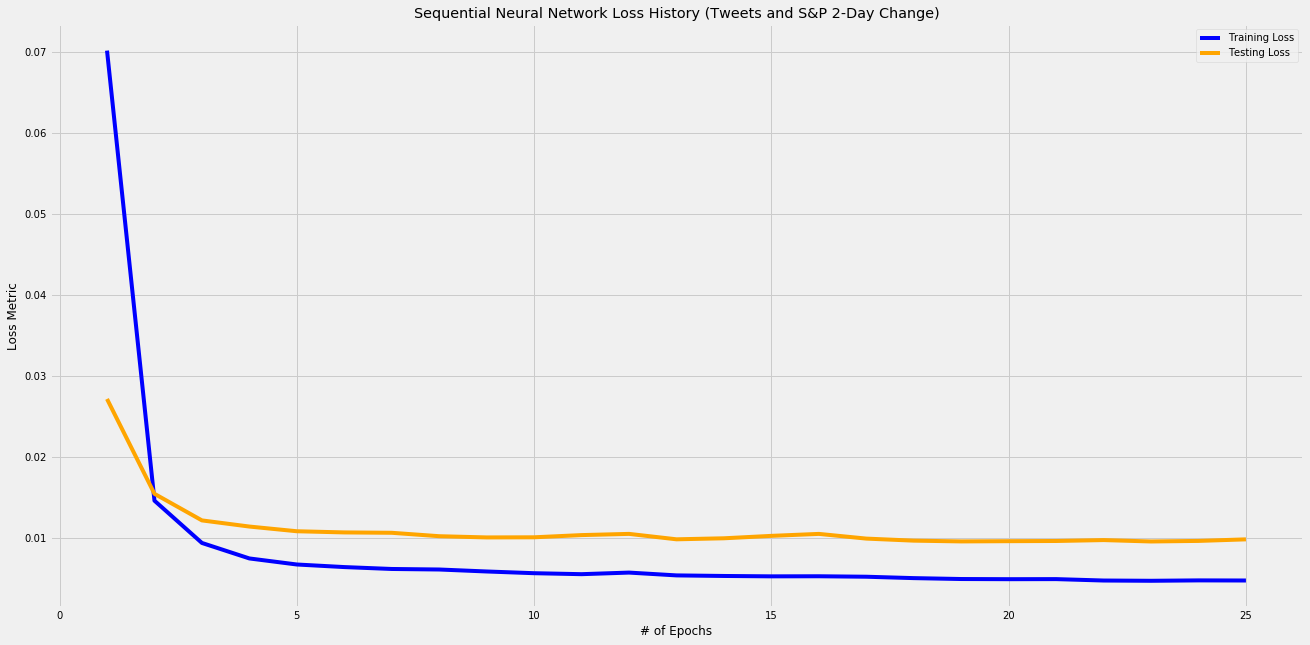

In [49]:
#Get training and test loss histories
training_loss = FitModel.history['loss']
test_loss = FitModel.history['val_loss']

#Create count of the number of epochs
#epoch count starts at 1...
xaxis = range(1, len(training_loss)+1)

#plot loss as a function of epochs
plt.plot(xaxis, training_loss, 'blue', label = "Training Loss")
plt.plot(xaxis, test_loss, 'orange', label = "Testing Loss")
plt.legend(loc = "best")
plt.xlabel('# of Epochs')
plt.ylabel('Loss Metric')
plt.title("Sequential Neural Network Loss History (Tweets and S&P 2-Day Change)")
plt.show();


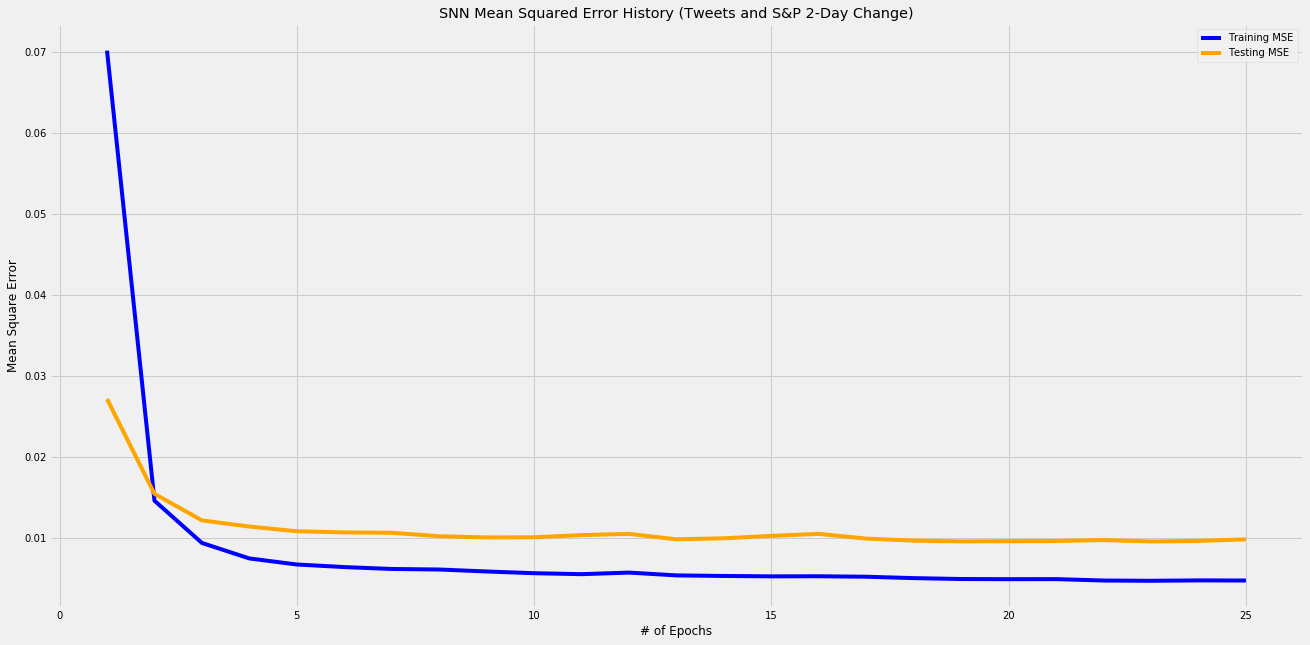

In [50]:
#Get training and testing accuracy histories
training_accuracy = FitModel.history['mean_squared_error']
testing_accuracy = FitModel.history['val_mean_squared_error']

#plot loss as a function of epochs
plt.plot(xaxis, training_accuracy, 'blue', label = "Training MSE")
plt.plot(xaxis, testing_accuracy, 'orange', label = "Testing MSE")
plt.legend(loc = "best")
plt.xlabel('# of Epochs')
plt.ylabel('Mean Square Error')
plt.title("SNN Mean Squared Error History (Tweets and S&P 2-Day Change)")
plt.show();


In [51]:
#seqModel.save('DJ_2-Day_v1.0.h5')

## Automating the SNN training process:
##### Same process as above, except inside of a function so that the process can be used iteratively

In [52]:
#define sequential neural network function that takes in X and y data
#model uses X and y data to split, train, and save a SNN model
def SNNRegression(X,target_index):
    
    y = merge_table_noNANS[target_index].values.reshape(-1,1)
    
    #split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    X_scaler = MinMaxScaler().fit(X_train)
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    #y data has to be scaled too!
    y_train_scaled = y_scaler.transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)
    
    #save out scaling parameters so that predictions can be returned to original scale
    XYscaleArr = [np.amax(X_train),np.amin(X_train),np.amax(X_test),np.amin(X_test),np.amax(y_train),np.amin(y_train),np.amax(y_test),np.amin(y_test)]
    
    #set up sequential model with linear output
    seqModel = Sequential()
    seqModel.add(Dense(units=30, activation='relu', input_dim=X.shape[1]))
    seqModel.add(Dense(units=100, activation='relu'))
    seqModel.add(Dense(units=1, activation = 'linear'))
    seqModel.compile(optimizer='adam',
                  loss='mse',
                    metrics=['mean_squared_error'])
    #Fit the model
    FitModel = seqModel.fit(
    X_train_scaled, 
    y_train_scaled, 
    epochs = 50, 
    shuffle=True,
    verbose=0,
    validation_data = (X_test_scaled, y_test_scaled))
    
    #Get training and test loss histories
    training_loss = FitModel.history['loss']
    test_loss = FitModel.history['val_loss']

    #Create count of the number of epochs
    #epoch count starts at 1...
    xaxis = range(1, len(training_loss)+1)
    
    #plot loss as a function of epochs
    plt.plot(xaxis, training_loss, 'blue', label = "Training Loss")
    plt.plot(xaxis, test_loss, 'orange', label = "Testing Loss")
    plt.legend(loc = "best")
    plt.xlabel('# of Epochs')
    plt.ylabel('Loss Metric')
    plt.title(f"Sequential Neural Network Loss History (Tweets and {target_index})")
    fname1 = "./output/plots/"+str(target_index)+"_Loss_History.png"
    plt.savefig(fname1)
    plt.close()       
    
    #Get training and testing accuracy histories
    training_accuracy = FitModel.history['mean_squared_error']
    testing_accuracy = FitModel.history['val_mean_squared_error']

    #plot loss as a function of epochs
    plt.plot(xaxis, training_accuracy, 'blue', label = "Training MSE")
    plt.plot(xaxis, testing_accuracy, 'orange', label = "Testing MSE")
    plt.legend(loc = "best")
    plt.xlabel('# of Epochs')
    plt.ylabel('Mean Square Error')
    plt.title(f"SNN Mean Squared Error History (Tweets and {target_index})")
    fname2 = "./output/plots/"+str(target_index)+"_MSE_History.png"
    plt.savefig(fname2)
    plt.close()
    
    #save out ML model generated to be used later
    modelname = "./output/ml_models/"+str(target_index)+".h5"
    seqModel.save(modelname)
    
    print(f'Finished modeling:', target_index)
    return XYscaleArr

In [53]:
scaleArr = []
#loop through all stockindices, create models
for name in colnames:
    scaleArr.append(SNNRegression(X,name))

Finished modeling: S&P500 Same-Day Change
Finished modeling: S&P500 1-Day Change
Finished modeling: S&P500 2-Day Change
Finished modeling: DJ_same_day Change
Finished modeling: DJ 1-Day Change
Finished modeling: DJ 2-Day Change
Finished modeling: NAS Same-Day Change
Finished modeling: NAS 1-Day Change
Finished modeling: NAS 2-Day Change
Finished modeling: CBOE Same-Day Change
Finished modeling: CBOE 1-Day Change
Finished modeling: CBOE 2-Day Change
Finished modeling: Russell2000 Same-Day Change
Finished modeling: Russell2000 1-Day Change
Finished modeling: Russell2000 2-Day Change


# Predicting Stock Market Change based on Tweet Sentiment

In [54]:

#select date range of tweets to predict from
start_date = "2020-05-19"
end_date = "2020-05-27"

tweet_stock_merged_marketdate = merge_table_noNANS.set_index('MarketDate')

In [55]:
data_for_daterange = tweet_stock_merged_marketdate.loc[start_date:end_date]
data_for_daterange

,Retweets,Likes,MarketDate_ms,Tweets,Vader_Sentiment_Compound,Vader_Sentiment_Positive,Vader_Sentiment_Negative,Vader_Sentiment_Neutral,TweetLength,nNicknames,...,NAS Same-Day Change,NAS 1-Day Change,NAS 2-Day Change,CBOE Same-Day Change,CBOE 1-Day Change,CBOE 2-Day Change,Russell2000 Same-Day Change,Russell2000 1-Day Change,Russell2000 2-Day Change,Date
MarketDate,,,,,,,,,,,,,,,,,,,,,
2020-05-19,25578.222222,91152.333333,1.589861e+09,9,0.147067,0.056111,0.021222,0.922667,63.222222,0.222222,...,-0.46,2.08,1.09,6.27,-8.32,-3.28,-1.70,3.00,3.05,2020-05-19
2020-05-20,18988.333333,84086.407407,1.589947e+09,27,0.476056,0.298889,0.060889,0.640259,151.370370,0.185185,...,0.75,-0.97,-0.55,-5.18,5.50,0.61,1.83,0.05,0.64,2020-05-20
2020-05-21,27603.666667,110707.222222,1.590034e+09,9,0.161500,0.218667,0.065556,0.715778,124.111111,0.000000,...,-0.96,0.43,0.60,1.93,-4.64,-5.15,0.14,0.59,3.38,2020-05-21
2020-05-22,20809.695652,90854.000000,1.590120e+09,23,0.100265,0.194739,0.079348,0.682435,104.913043,0.086957,...,0.50,0.17,0.94,-10.20,-0.53,-1.92,0.45,2.77,5.96,2020-05-22
2020-05-26,26295.000000,111785.312500,1.590466e+09,16,0.006969,0.107938,0.083375,0.808750,199.312500,0.375000,...,-1.69,0.77,0.31,1.05,-1.39,2.07,2.34,3.11,0.55,2020-05-26
2020-05-27,36558.894737,147529.526316,1.590552e+09,19,0.008847,0.114737,0.099316,0.785895,191.000000,0.157895,...,0.71,-0.46,0.00,0.00,3.51,0.00,2.71,-2.48,0.00,2020-05-27


In [56]:
outcomes = data_for_daterange[['S&P500 Same-Day Change',
       'S&P500 1-Day Change', 'S&P500 2-Day Change','DJ_same_day Change',
       'DJ 1-Day Change', 'DJ 2-Day Change', 'NAS Same-Day Change',
       'NAS 1-Day Change', 'NAS 2-Day Change', 'CBOE Same-Day Change',
       'CBOE 1-Day Change', 'CBOE 2-Day Change', 'Russell2000 Same-Day Change',
       'Russell2000 1-Day Change', 'Russell2000 2-Day Change']]
outcomes

,S&P500 Same-Day Change,S&P500 1-Day Change,S&P500 2-Day Change,DJ_same_day Change,DJ 1-Day Change,DJ 2-Day Change,NAS Same-Day Change,NAS 1-Day Change,NAS 2-Day Change,CBOE Same-Day Change,CBOE 1-Day Change,CBOE 2-Day Change,Russell2000 Same-Day Change,Russell2000 1-Day Change,Russell2000 2-Day Change
MarketDate,,,,,,,,,,,,,,,
2020-05-19,-0.87,1.67,0.87,-1.51,1.52,1.10,-0.46,2.08,1.09,6.27,-8.32,-3.28,-1.70,3.00,3.05
2020-05-20,0.61,-0.78,-0.54,0.49,-0.41,-0.45,0.75,-0.97,-0.55,-5.18,5.50,0.61,1.83,0.05,0.64
2020-05-21,-0.72,0.24,1.47,-0.37,-0.04,2.13,-0.96,0.43,0.60,1.93,-4.64,-5.15,0.14,0.59,3.38
2020-05-22,0.25,1.23,2.73,0.01,2.17,4.43,0.50,0.17,0.94,-10.20,-0.53,-1.92,0.45,2.77,5.96
2020-05-26,-0.41,1.48,1.27,0.86,2.21,1.62,-1.69,0.77,0.31,1.05,-1.39,2.07,2.34,3.11,0.55
2020-05-27,0.68,-0.21,0.00,0.99,-0.58,0.00,0.71,-0.46,0.00,0.00,3.51,0.00,2.71,-2.48,0.00


In [57]:
X_showOff = data_for_daterange.drop(columns=['S&P500 Same-Day Change',
       'S&P500 1-Day Change', 'S&P500 2-Day Change','DJ_same_day Change',
       'DJ 1-Day Change', 'DJ 2-Day Change', 'NAS Same-Day Change',
       'NAS 1-Day Change', 'NAS 2-Day Change', 'CBOE Same-Day Change',
       'CBOE 1-Day Change', 'CBOE 2-Day Change', 'Russell2000 Same-Day Change',
       'Russell2000 1-Day Change', 'Russell2000 2-Day Change', 'Date'])
print(f'Feature columns:', X_showOff.columns)
X_showOff = X_showOff.values
print("-"*120)
print("X:")
print(X_showOff)

Feature columns: Index(['Retweets', 'Likes', 'MarketDate_ms', 'Tweets',
       'Vader_Sentiment_Compound', 'Vader_Sentiment_Positive',
       'Vader_Sentiment_Negative', 'Vader_Sentiment_Neutral', 'TweetLength',
       'nNicknames', 'nKeywords', 'domestic_figures', 'foreign_figures',
       'media_figures', 'groups', 'other_people', 'organizations', 'tv',
       'misc', 'financial', 'economy', 'foreign', 'political_issues',
       'military', 'subjective', 'brags', 'date_lag'],
      dtype='object')
------------------------------------------------------------------------------------------------------------------------
X:
[[2.55782222e+04 9.11523333e+04 1.58986080e+09 9.00000000e+00
  1.47066667e-01 5.61111111e-02 2.12222222e-02 9.22666667e-01
  6.32222222e+01 2.22222222e-01 2.22222222e-01 0.00000000e+00
  0.00000000e+00 1.11111111e-01 0.00000000e+00 0.00000000e+00
  1.11111111e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00

In [58]:
from keras.models import load_model
print(colnames)
#scale X values
X_showOff_scaled = X_scaler.transform(X_showOff)

predArr = []
for i in range(0,len(colnames)):
    modelpath = "./output/ml_models/"+str(colnames[i])+".h5"
    trained_model = load_model(modelpath)
    output = trained_model.predict(X_showOff_scaled)
    predArr.append(output.flatten())
predArr = y_scaler.inverse_transform(predArr)
predArr

['S&P500 Same-Day Change', 'S&P500 1-Day Change', 'S&P500 2-Day Change', 'DJ_same_day Change', 'DJ 1-Day Change', 'DJ 2-Day Change', 'NAS Same-Day Change', 'NAS 1-Day Change', 'NAS 2-Day Change', 'CBOE Same-Day Change', 'CBOE 1-Day Change', 'CBOE 2-Day Change', 'Russell2000 Same-Day Change', 'Russell2000 1-Day Change', 'Russell2000 2-Day Change']


array([[-0.9332593 , -0.18414406, -0.20557973,  0.52526372, -0.46261344,
         1.35574864],
       [ 0.63884061, -0.8257244 ,  0.12842707, -0.19874013,  0.74028984,
        -1.17101639],
       [ 0.35996269, -0.07758034,  0.74214955,  1.09239368,  1.2531151 ,
        -0.90499349],
       [-0.19843313,  0.10687511, -0.1404462 , -0.29184782,  0.12778828,
         1.04155099],
       [ 1.10063898, -0.47669528, -0.47673247, -0.03589569,  0.55668986,
         0.10411093],
       [ 0.21002877, -0.81836999,  0.99091257,  1.77200478,  1.4439957 ,
        -0.16459468],
       [-0.83836452,  0.99928304,  0.49688219,  0.25398463,  0.46563789,
         1.03623754],
       [ 2.12738171, -0.65666145,  0.68024661,  0.81129533,  1.74825718,
         0.10856301],
       [-0.05644695, -0.93211396,  0.82147591,  0.67568589,  0.24393807,
        -0.54919089],
       [ 4.7251292 , -2.10311112, -1.21211243, -2.19982723, -1.03301767,
         3.99686219],
       [-3.93049485,  4.38611417,  4.02045039, -0.

In [59]:
#make column names for predictions
predcolnames = [name+"_pred" for name in colnames]
predcolnames

['S&P500 Same-Day Change_pred',
 'S&P500 1-Day Change_pred',
 'S&P500 2-Day Change_pred',
 'DJ_same_day Change_pred',
 'DJ 1-Day Change_pred',
 'DJ 2-Day Change_pred',
 'NAS Same-Day Change_pred',
 'NAS 1-Day Change_pred',
 'NAS 2-Day Change_pred',
 'CBOE Same-Day Change_pred',
 'CBOE 1-Day Change_pred',
 'CBOE 2-Day Change_pred',
 'Russell2000 Same-Day Change_pred',
 'Russell2000 1-Day Change_pred',
 'Russell2000 2-Day Change_pred']

In [60]:
#add predictions to outcomes dataframe
for i in range(0,len(predcolnames)):
    outcomes[predcolnames[i]] = predArr[i]
outcomes

,S&P500 Same-Day Change,S&P500 1-Day Change,S&P500 2-Day Change,DJ_same_day Change,DJ 1-Day Change,DJ 2-Day Change,NAS Same-Day Change,NAS 1-Day Change,NAS 2-Day Change,CBOE Same-Day Change,...,DJ 2-Day Change_pred,NAS Same-Day Change_pred,NAS 1-Day Change_pred,NAS 2-Day Change_pred,CBOE Same-Day Change_pred,CBOE 1-Day Change_pred,CBOE 2-Day Change_pred,Russell2000 Same-Day Change_pred,Russell2000 1-Day Change_pred,Russell2000 2-Day Change_pred
MarketDate,,,,,,,,,,,,,,,,,,,,,
2020-05-19,-0.87,1.67,0.87,-1.51,1.52,1.10,-0.46,2.08,1.09,6.27,...,0.210029,-0.838365,2.127382,-0.056447,4.725129,-3.930495,2.873945,-1.325693,0.043003,0.869768
2020-05-20,0.61,-0.78,-0.54,0.49,-0.41,-0.45,0.75,-0.97,-0.55,-5.18,...,-0.818370,0.999283,-0.656661,-0.932114,-2.103111,4.386114,9.877508,0.401790,-0.699454,-1.057756
2020-05-21,-0.72,0.24,1.47,-0.37,-0.04,2.13,-0.96,0.43,0.60,1.93,...,0.990913,0.496882,0.680247,0.821476,-1.212112,4.020450,2.789781,0.386872,0.491674,2.217387
2020-05-22,0.25,1.23,2.73,0.01,2.17,4.43,0.50,0.17,0.94,-10.20,...,1.772005,0.253985,0.811295,0.675686,-2.199827,-0.260781,0.981692,-0.306538,0.377417,1.469983
2020-05-26,-0.41,1.48,1.27,0.86,2.21,1.62,-1.69,0.77,0.31,1.05,...,1.443996,0.465638,1.748257,0.243938,-1.033018,-4.845911,2.062680,0.995894,1.179736,0.065271
2020-05-27,0.68,-0.21,0.00,0.99,-0.58,0.00,0.71,-0.46,0.00,0.00,...,-0.164595,1.036238,0.108563,-0.549191,3.996862,1.087630,0.857853,0.578038,0.134483,0.852098


In [64]:
#calculate percent error for each prediction vs. actual
for j in range(0,len(colnames)):
    outcomes[str(colnames[j])+"_pcterr"] = ((outcomes[predcolnames[j]]-outcomes[colnames[j]])/outcomes[colnames[j]])*100
outcomes

,S&P500 Same-Day Change,S&P500 1-Day Change,S&P500 2-Day Change,DJ_same_day Change,DJ 1-Day Change,DJ 2-Day Change,NAS Same-Day Change,NAS 1-Day Change,NAS 2-Day Change,CBOE Same-Day Change,...,DJ 2-Day Change_pcterr,NAS Same-Day Change_pcterr,NAS 1-Day Change_pcterr,NAS 2-Day Change_pcterr,CBOE Same-Day Change_pcterr,CBOE 1-Day Change_pcterr,CBOE 2-Day Change_pcterr,Russell2000 Same-Day Change_pcterr,Russell2000 1-Day Change_pcterr,Russell2000 2-Day Change_pcterr
MarketDate,,,,,,,,,,,,,,,,,,,,,
2020-05-19,-0.87,1.67,0.87,-1.51,1.52,1.10,-0.46,2.08,1.09,6.27,...,-80.906475,82.253157,2.277967,-105.178620,-24.639088,-52.758475,-187.620266,-22.018032,-98.566579,-71.483012
2020-05-20,0.61,-0.78,-0.54,0.49,-0.41,-0.45,0.75,-0.97,-0.55,-5.18,...,81.859997,33.237739,-32.302944,69.475265,-59.399399,-20.252470,1519.263677,-78.044250,-1498.907318,-265.274366
2020-05-21,-0.72,0.24,1.47,-0.37,-0.04,2.13,-0.96,0.43,0.60,1.93,...,-53.478283,-151.758561,58.196885,36.912651,-162.803753,-186.647638,-154.170500,176.337425,-16.665354,-34.396836
2020-05-22,0.25,1.23,2.73,0.01,2.17,4.43,0.50,0.17,0.94,-10.20,...,-59.999892,-49.203074,377.232544,-28.118522,-78.433066,-50.796107,-151.129789,-168.119632,-86.374845,-75.335852
2020-05-26,-0.41,1.48,1.27,0.86,2.21,1.62,-1.69,0.77,0.31,1.05,...,-10.864463,-127.552538,127.046387,-21.310301,-198.382635,248.626665,-0.353606,-57.440417,-62.066358,-88.132485
2020-05-27,0.68,-0.21,0.00,0.99,-0.58,0.00,0.71,-0.46,0.00,0.00,...,-inf,45.948949,-123.600655,-inf,inf,-69.013377,inf,-78.670201,-105.422711,inf


In [ ]:
for i in range(0,len(colnames)):
    outcomes[str(colnames[j])+"_directionallyCorrect"] = outcomes.apply(lambda x: 1 if (np.sign(x[predcolnames[j]]) == np.sign(x[colnames[j]]))
outcomes

In [62]:
#highlight predictions related to S&P
SPOutcomes = outcomes[['S&P500 Same-Day Change','S&P500 1-Day Change', 'S&P500 2-Day Change',
          'S&P500 Same-Day Change_pred','S&P500 1-Day Change_pred', 'S&P500 2-Day Change_pred',
          'S&P500 Same-Day Change_pcterr','S&P500 1-Day Change_pcterr', 'S&P500 2-Day Change_pcterr'
         ]].round(2)
SPOutcomes

,S&P500 Same-Day Change,S&P500 1-Day Change,S&P500 2-Day Change,S&P500 Same-Day Change_pred,S&P500 1-Day Change_pred,S&P500 2-Day Change_pred,S&P500 Same-Day Change_pcterr,S&P500 1-Day Change_pcterr,S&P500 2-Day Change_pcterr
MarketDate,,,,,,,,,
2020-05-19,-0.87,1.67,0.87,-0.93,0.64,0.36,7.27,-61.75,-58.62
2020-05-20,0.61,-0.78,-0.54,-0.18,-0.83,-0.08,-130.19,5.86,-85.63
2020-05-21,-0.72,0.24,1.47,-0.21,0.13,0.74,-71.45,-46.49,-49.51
2020-05-22,0.25,1.23,2.73,0.53,-0.20,1.09,110.11,-116.16,-59.99
2020-05-26,-0.41,1.48,1.27,-0.46,0.74,1.25,12.83,-49.98,-1.33
2020-05-27,0.68,-0.21,0.00,1.36,-1.17,-0.90,99.37,457.63,-inf


In [63]:
#highlight predictions related to the DJIA
DJOutcomes = outcomes[['DJ_same_day Change', 'DJ 1-Day Change', 'DJ 2-Day Change',
                      'DJ_same_day Change_pred','DJ 1-Day Change_pred','DJ 2-Day Change_pred',
                      'DJ_same_day Change_pcterr', 'DJ 1-Day Change_pcterr', 'DJ 2-Day Change_pcterr']].round(2)
DJOutcomes

,DJ_same_day Change,DJ 1-Day Change,DJ 2-Day Change,DJ_same_day Change_pred,DJ 1-Day Change_pred,DJ 2-Day Change_pred,DJ_same_day Change_pcterr,DJ 1-Day Change_pcterr,DJ 2-Day Change_pcterr
MarketDate,,,,,,,,,
2020-05-19,-1.51,1.52,1.10,-0.20,1.10,0.21,-86.86,-27.59,-80.91
2020-05-20,0.49,-0.41,-0.45,0.11,-0.48,-0.82,-78.19,16.27,81.86
2020-05-21,-0.37,-0.04,2.13,-0.14,-0.48,0.99,-62.04,1091.83,-53.48
2020-05-22,0.01,2.17,4.43,-0.29,-0.04,1.77,-3018.48,-101.65,-60.00
2020-05-26,0.86,2.21,1.62,0.13,0.56,1.44,-85.14,-74.81,-10.86
2020-05-27,0.99,-0.58,0.00,1.04,0.10,-0.16,5.21,-117.95,-inf
